In [28]:
#Notebook for COVID-19 reference genome
#Data from https://www.kaggle.com/paultimothymooney/coronavirus-genome-sequence
def readGenome(filename):
    genome = ''
    with open(filename, 'r') as f:
        for line in f:
            # ignore header line with genome information
            if not line[0] == '>':
                genome += line.rstrip()
    return genome
genome = readGenome('MN908947.txt')


In [29]:
def de_bruijn_ize(st, k):
    """ Return a list holding, for each k-mer, its left
        k-1-mer and its right k-1-mer in a pair """
    edges = []
    nodes = set()
    for i in range(len(st) - k + 1):
        edges.append((st[i:i+k-1], st[i+1:i+k]))
        nodes.add(st[i:i+k-1])
        nodes.add(st[i+1:i+k])
    return nodes, edges


In [30]:
nodes, edges = de_bruijn_ize(genome, 10)


In [31]:
#Counting bases
counts = {'A': 0, 'C': 0, 'G': 0, 'T': 0}
for base in genome:
    counts[base] += 1
print(counts)

{'A': 8954, 'C': 5492, 'T': 9594, 'G': 5863}


In [32]:
from sklearn.cluster import KMeans

In [33]:
import scipy.io

from numpy import argmax

X=[]

for i in range(0,len(lines)):
    
    data=lines[i]
    alphabet = 'ATGC'
# define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
# integer encode input data
    integer_encoded = [char_to_int[char] for char in data]
    X.append(integer_encoded)

X=np.array(X)

In [34]:
#PCA for Kmeans
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

In [35]:
#Kmeans
kmeans = KMeans(n_clusters=30, random_state=0).fit(principalComponents)

y_kmeans=kmeans.predict(principalComponents)

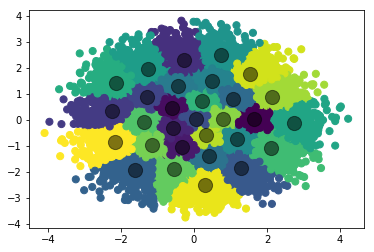

In [36]:
#Clusters of fragments of the COVID-19 virus based on sequence similarity
import matplotlib.pyplot as plt
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.show()


In [37]:
#Approximate matching algorithm for identifying COVID-like virus inside larger genome. Big thanks to Algorithms for DNA sequencing course 
#notebooks at Coursera for the work.
import string

def z_array(s):
    """ Use Z algorithm (Gusfield theorem 1.4.1) to preprocess s """
    assert len(s) > 1
    z = [len(s)] + [0] * (len(s)-1)
    # Initial comparison of s[1:] with prefix
    for i in range(1, len(s)):
        if s[i] == s[i-1]:
            z[1] += 1
        else:
            break
    r, l = 0, 0
    if z[1] > 0:
        r, l = z[1], 1
    for k in range(2, len(s)):
        assert z[k] == 0
        if k > r:
            # Case 1
            for i in range(k, len(s)):
                if s[i] == s[i-k]:
                    z[k] += 1
                else:
                    break
            r, l = k + z[k] - 1, k
        else:
            # Case 2
            # Calculate length of beta
            nbeta = r - k + 1
            zkp = z[k - l]
            if nbeta > zkp:
                # Case 2a: Zkp wins
                z[k] = zkp
            else:
                # Case 2b: Compare characters just past r
                nmatch = 0
                for i in range(r+1, len(s)):
                    if s[i] == s[i - k]:
                        nmatch += 1
                    else:
                        break
                l, r = k, r + nmatch
                z[k] = r - k + 1
    return z


In [38]:
import string

def z_array(s):
    """ Use Z algorithm (Gusfield theorem 1.4.1) to preprocess s """
    assert len(s) > 1
    z = [len(s)] + [0] * (len(s)-1)
    # Initial comparison of s[1:] with prefix
    for i in range(1, len(s)):
        if s[i] == s[i-1]:
            z[1] += 1
        else:
            break
    r, l = 0, 0
    if z[1] > 0:
        r, l = z[1], 1
    for k in range(2, len(s)):
        assert z[k] == 0
        if k > r:
            # Case 1
            for i in range(k, len(s)):
                if s[i] == s[i-k]:
                    z[k] += 1
                else:
                    break
            r, l = k + z[k] - 1, k
        else:
            # Case 2
            # Calculate length of beta
            nbeta = r - k + 1
            zkp = z[k - l]
            if nbeta > zkp:
                # Case 2a: Zkp wins
                z[k] = zkp
            else:
                # Case 2b: Compare characters just past r
                nmatch = 0
                for i in range(r+1, len(s)):
                    if s[i] == s[i - k]:
                        nmatch += 1
                    else:
                        break
                l, r = k, r + nmatch
                z[k] = r - k + 1
    return z


def n_array(s):
    """ Compile the N array (Gusfield theorem 2.2.2) from the Z array """
    return z_array(s[::-1])[::-1]


def big_l_prime_array(p, n):
    """ Compile L' array (Gusfield theorem 2.2.2) using p and N array.
        L'[i] = largest index j less than n such that N[j] = |P[i:]| """
    lp = [0] * len(p)
    for j in range(len(p)-1):
        i = len(p) - n[j]
        if i < len(p):
            lp[i] = j + 1
    return lp


def big_l_array(p, lp):
    """ Compile L array (Gusfield theorem 2.2.2) using p and L' array.
        L[i] = largest index j less than n such that N[j] >= |P[i:]| """
    l = [0] * len(p)
    l[1] = lp[1]
    for i in range(2, len(p)):
        l[i] = max(l[i-1], lp[i])
    return l


def small_l_prime_array(n):
    """ Compile lp' array (Gusfield theorem 2.2.4) using N array. """
    small_lp = [0] * len(n)
    for i in range(len(n)):
        if n[i] == i+1:  # prefix matching a suffix
            small_lp[len(n)-i-1] = i+1
    for i in range(len(n)-2, -1, -1):  # "smear" them out to the left
        if small_lp[i] == 0:
            small_lp[i] = small_lp[i+1]
    return small_lp


def good_suffix_table(p):
    """ Return tables needed to apply good suffix rule. """
    n = n_array(p)
    lp = big_l_prime_array(p, n)
    return lp, big_l_array(p, lp), small_l_prime_array(n)


def good_suffix_mismatch(i, big_l_prime, small_l_prime):
    """ Given a mismatch at offset i, and given L/L' and l' arrays,
        return amount to shift as determined by good suffix rule. """
    length = len(big_l_prime)
    assert i < length
    if i == length - 1:
        return 0
    i += 1  # i points to leftmost matching position of P
    if big_l_prime[i] > 0:
        return length - big_l_prime[i]
    return length - small_l_prime[i]


def good_suffix_match(small_l_prime):
    """ Given a full match of P to T, return amount to shift as
        determined by good suffix rule. """
    return len(small_l_prime) - small_l_prime[1]


def dense_bad_char_tab(p, amap):
    """ Given pattern string and list with ordered alphabet characters, create
        and return a dense bad character table.  Table is indexed by offset
        then by character. """
    tab = []
    nxt = [0] * len(amap)
    for i in range(0, len(p)):
        c = p[i]
        assert c in amap
        tab.append(nxt[:])
        nxt[amap[c]] = i+1
    return tab


class BoyerMoore(object):
    """ Encapsulates pattern and associated Boyer-Moore preprocessing. """
    
    def __init__(self, p, alphabet='ACGT'):
        self.p = p
        self.alphabet = alphabet
        # Create map from alphabet characters to integers
        self.amap = {}
        for i in range(len(self.alphabet)):
            self.amap[self.alphabet[i]] = i
        # Make bad character rule table
        self.bad_char = dense_bad_char_tab(p, self.amap)
        # Create good suffix rule table
        _, self.big_l, self.small_l_prime = good_suffix_table(p)
    
    def bad_character_rule(self, i, c):
        """ Return # skips given by bad character rule at offset i """
        assert c in self.amap
        ci = self.amap[c]
        assert i > (self.bad_char[i][ci]-1)
        return i - (self.bad_char[i][ci]-1)
    
    def good_suffix_rule(self, i):
        """ Given a mismatch at offset i, return amount to shift
            as determined by (weak) good suffix rule. """
        length = len(self.big_l)
        assert i < length
        if i == length - 1:
            return 0
        i += 1  # i points to leftmost matching position of P
        if self.big_l[i] > 0:
            return length - self.big_l[i]
        return length - self.small_l_prime[i]
    
    def match_skip(self):
        """ Return amount to shift in case where P matches T """
        return len(self.small_l_prime) - self.small_l_prime[1]

In [39]:
def boyer_moore(p, p_bm, t):
    """ Do Boyer-Moore matching """
    i = 0
    occurrences = []
    while i < len(t) - len(p) + 1:
        shift = 1
        mismatched = False
        for j in range(len(p)-1, -1, -1):
            if p[j] != t[i+j]:
                skip_bc = p_bm.bad_character_rule(j, t[i+j])
                skip_gs = p_bm.good_suffix_rule(j)
                shift = max(shift, skip_bc, skip_gs)
                mismatched = True
                break
        if not mismatched:
            occurrences.append(i)
            skip_gs = p_bm.match_skip()
            shift = max(shift, skip_gs)
        i += shift
    return occurrences

In [40]:
def approximate_match(p, t, n):
    segment_length = int(round(len(p) / (n+1)))
    all_matches = set()
    for i in range(n+1):
        start = i*segment_length
        end = min((i+1)*segment_length, len(p))
        p_bm = BoyerMoore(p[start:end], alphabet='ACGT')
        matches = boyer_moore(p[start:end], p_bm, t)
        # Extend matching segments to see if whole p matches
        for m in matches:
            if m < start or m-start+len(p) > len(t):
                continue
            mismatches = 0
            for j in range(0, start):
                if not p[j] == t[m-start+j]:
                    mismatches += 1
                    if mismatches > n:
                        break
            for j in range(end, len(p)):
                if not p[j] == t[m-start+j]:
                    mismatches += 1
                    if mismatches > n:
                        break
            if mismatches <= n:
                all_matches.add(m - start)
    return list(all_matches)

In [ ]:
#Example. For real use, combine this with DNA notebook.
#p = 'AACTTG'
#t = 'CACTTAATTTG'
#print(approximate_match(p, t, 2))


In [44]:
#Gives a way to measure how a sequenced strain compares to reference strain. Worth repeating over many identified strains.
def editDistance(x, y):
    # Create distance matrix
    D = []
    for i in range(len(x)+1):
        D.append([0]*(len(y)+1))
    # Initialize first row and column of matrix
    for i in range(len(x)+1):
        D[i][0] = i
    for i in range(len(y)+1):
        D[0][i] = i
    # Fill in the rest of the matrix
    for i in range(1, len(x)+1):
        for j in range(1, len(y)+1):
            distHor = D[i][j-1] + 1
            distVer = D[i-1][j] + 1
            if x[i-1] == y[j-1]:
                distDiag = D[i-1][j-1]
            else:
                distDiag = D[i-1][j-1] + 1
            D[i][j] = min(distHor, distVer, distDiag)
    # Edit distance is the value in the bottom right corner of the matrix
    return D[-1][-1]


In [45]:
#Example of the edit distance function
%%time
x = 'shake spea'
y = 'Shakespear'
editDistance(x, y)

CPU times: user 373 µs, sys: 50 µs, total: 423 µs
Wall time: 431 µs
